In [1]:
import numpy as np

In [2]:
# 1) Read the csv file containing the mag data (already organized as T, H, M)
fulldata = np.loadtxt("HEO-MCE-emugT-20220710-2.csv", dtype='f8', delimiter=',', encoding='utf-8')
print(fulldata)

[[2.00137889e+00 7.06769350e-02 9.08863630e-02]
 [2.00019306e+00 2.12072437e-01 4.52671303e-01]
 [1.99970782e+00 3.53505859e-01 6.92100753e-01]
 ...
 [2.99863350e+02 7.00003594e+00 1.85073683e+00]
 [2.99890360e+02 7.00003594e+00 1.84985657e+00]
 [2.99911220e+02 7.00003594e+00 1.84985657e+00]]


In [3]:
# col 0 = T, col 1 = H, col 2 = M
def Hchanged(row1,row2):
    return (True if abs(row2[1]-row1[1]) >= 0.1 else False)

# Allow larger T variation to be the same (i.e. "not changed") when H is changing too
def Tchanged(row1,row2):
    tol = (0.5) if Hchanged(row1,row2) else (0.02)
    return (True if abs(row2[0]-row1[0]) >= tol else False)

# Identify starts of new measurements
measurements = []
lastStart = 0
for i in range(1,len(fulldata)):
    if Hchanged(fulldata[i],fulldata[i-1]) and Tchanged(fulldata[i],fulldata[i-1]):
        measurements.append((lastStart,i-1))
        lastStart = i
measurements.append((lastStart,len(fulldata)-1))

# Classify each as a M(T) or M(H). Because we have tight H,T tolerances,
# an occassional transition in an M(T) might be erroniously identified as an M(H)
# or vice versa, so we just count "predominace" (i.e. were there more T or H changes?)
# we warn if there seem to be a lot of both in a given measurements
MTs = {} # keys are the field
MHs = {} # keys are the temp
for i,j in measurements:
    numH = 0
    numT = 0
    for k in range(i+1,j+1):
        numH += 1 if Hchanged(fulldata[k],fulldata[k-1]) else 0
        numT += 1 if Tchanged(fulldata[k],fulldata[k-1]) else 0
    if numH > numT:
        # we are an M(H)
        MHs[np.mean(fulldata[i:(j+1),0])] = fulldata[i:(j+1),[False,True,True]]
    else:
        # we are an M(T)
        MTs[np.mean(fulldata[i:(j+1),1])] = fulldata[i:(j+1),[True,False,True]]

# Add a M = 0 at H = 0 M(T)
MTs[0.0] = np.array((range(2,350)))
MTs[0.0] = np.array([MTs[0.0],np.zeros(len(MTs[0.0]))]).transpose()
print(MHs)

{2.0002788376: array([[0.07067693, 0.09088636],
       [0.21207244, 0.4526713 ],
       [0.35350586, 0.69210075],
       [0.49493569, 0.89830056],
       [0.63635195, 1.10075929],
       [0.77778545, 1.29639604],
       [0.91920059, 1.49115253],
       [1.06065234, 1.68854978],
       [1.20204668, 1.87934513],
       [1.34346543, 2.07124079],
       [1.48489395, 2.26093581],
       [1.62627832, 2.45063084],
       [1.76770566, 2.63900548],
       [1.9091293 , 2.82561961],
       [2.05054453, 3.01443437],
       [2.19195586, 3.20060838],
       [2.33335137, 3.3848018 ],
       [2.4747873 , 3.57207613],
       [2.61619609, 3.75516923],
       [2.75760781, 3.93892253],
       [2.89900801, 4.11981501],
       [3.04042695, 4.30092754],
       [3.18185527, 4.48622129],
       [3.3232793 , 4.66557331],
       [3.46469766, 4.83920367],
       [3.60610703, 5.02031621],
       [3.74749141, 5.19614721],
       [3.88892344, 5.38386166],
       [4.03034336, 5.55661177],
       [4.17174766, 5.719679

In [4]:
# Do interpolation
# def getM(T, H):
    # returns interpolated M for given T and H
    # 1) Identify "bounding" M(H)s ... i.e.
    #   M(H)1 is Tlow <= Tinput
    #   M(H)2 is Thigh >= Tinput
    #   kMHlow = -1
    #   kMHhigh = 10000
    #   foreach k in MHs.keys():
    #      if k <= Tinput and k > kMHlow:
    #          kMHlow = k
    #      if k > Tinput and k < kMHhigh:
    #          kMHhigh = k
    # 2) Identify "bounding" M(T)s ... i.e.
    #   M(T)1 is Hlow <= Hinput
    #   M(T)2 is Hhigh >= Hinput
    #   kMTkow = -10000000
    #   kMThigh = 10000000
    #   foreach k in MTs.keys():
    #      if k <= Hinput and k > kMTlow:
    #          kMTlow = k
    #      if k > Hinput and k < kMThigh:
    #          kMThigh = k
    # 3) Actually do the interpolation:
    #   MfromMH1 at Hlow:
    #      interp1d(M(H)1 at Hlow)
    #      interp1d is a python function from numpy
    #   MfromMH2 at Hlow:
    #      interp1d(M(H)2 at Hlow)
    #   MfromMH1 at Hhigh:
    #      interp1d(M(H)1 at Hhigh)
    #   MfromMH2 at Hhigh:
    #      interp1d(M(H)2 at Hhigh)
    #   MfromMT1 at T:
    #      interp1d(M(T)1 at T)
    #   MfromMT2 at T:
    #      interp1d(M(T)2 at T)
    #   fract1 = (MfromMT1-(MfromMH1 at Hlow))/((MfromMH2 at Hlow)-(MfromMH1 at HLow))
    #   fract2 = (MfromMT2-(MfromMH1 at Hhigh))/((MfromMH2 at Hhigh)-(MfromMH1 at Hhigh))
    #   fract = (H-Hlow)/(Hhigh-Hlow)*fract2+(1-(H-Hlow)/(Hhigh-Hlow))*fract1
    #   MfromMH1 at Hinput:
    #      interp1d(M(H)1 at Hinput)
    #   MfromMH2 at Hinput:
    #      interp1d(M(H)2 at Hinput)
    # M = fract*((MfromMH2 at Hinput)-(MfromMH1 at Hinput))+(MfromMH1 at Hinput)
from scipy.interpolate import interp1d

def getM(T, H):
    kMHlow = -1
    kMHhigh = 350
    for k in MHs.keys():
        if k <= T and k > kMHlow:
            kMHlow = k
        if k > T and k < kMHhigh:
            kMHhigh = k
    kMTlow = -75000
    kMThigh = 75000
    for k in MTs.keys():
        if k <= H and k > kMTlow:
            kMTlow = k
        if k > H and k < kMThigh:
            kMThigh = k
    MfromMH1_low = interp1d(MHs[kMHlow][:,0],MHs[kMHlow][:,1],bounds_error=False,fill_value=(0.0,max(MHs[kMHlow][:,1])))(kMTlow)
    MfromMH2_low = interp1d(MHs[kMHhigh][:,0],MHs[kMHhigh][:,1],bounds_error=False,fill_value=(0.0,max(MHs[kMHhigh][:,1])))(kMTlow)
    MfromMH1_high = interp1d(MHs[kMHlow][:,0],MHs[kMHlow][:,1],bounds_error=False,fill_value=(0.0,max(MHs[kMHlow][:,1])))(kMThigh)
    MfromMH2_high = interp1d(MHs[kMHhigh][:,0],MHs[kMHhigh][:,1],bounds_error=False,fill_value=(0.0,max(MHs[kMHhigh][:,1])))(kMThigh)
    MfromMT1 = interp1d(MTs[kMTlow][:,0],MTs[kMTlow][:,1],bounds_error=False,fill_value="extrapolate")(T)
    MfromMT2 = interp1d(MTs[kMThigh][:,0],MTs[kMThigh][:,1],bounds_error=False,fill_value="extrapolate")(T)
    if MfromMT1 < min((MfromMH1_low,MfromMH2_low)):
        MfromMT1 = min((MfromMH1_low,MfromMH2_low))
    if MfromMT1 > max((MfromMH1_low,MfromMH2_low)):
        MfromMT1 = max((MfromMH1_low,MfromMH2_low))
    if MfromMH2_low != MfromMH1_low:
        fract1 = (MfromMT1-(MfromMH1_low))/((MfromMH2_low)-(MfromMH1_low))
    else:
        fract1 = 0.5
    if MfromMT2 < min((MfromMH1_high,MfromMH2_high)):
        MfromMT2 = min((MfromMH1_high,MfromMH2_high))
    if MfromMT2 > max((MfromMH1_high,MfromMH2_high)):
        MfromMT2 = max((MfromMH1_high,MfromMH2_high))
    if MfromMH2_high != MfromMH1_high:
        fract2 = (MfromMT2-(MfromMH1_high))/((MfromMH2_high)-(MfromMH1_high))
    else:
        fract2 = 0.5
    fract = (H-kMTlow)/(kMThigh-kMTlow)*fract2+(1-((H-kMTlow)/(kMThigh-kMTlow)))*fract1
    MfromMH1 = interp1d(MHs[kMHlow][:,0],MHs[kMHlow][:,1],bounds_error=False,fill_value=(0.0,max(MHs[kMHlow][:,1])))(H)
    MfromMH2 = interp1d(MHs[kMHhigh][:,0],MHs[kMHhigh][:,1],bounds_error=False,fill_value=(0.0,max(MHs[kMHhigh][:,1])))(H)
    M = fract*((MfromMH2)-(MfromMH1))+(MfromMH1)
#    print(MfromMH1_low,MfromMH2_low,MfromMH1_high,MfromMH2_high,MfromMT1,MfromMT2,fract1,fract2,fract,MfromMH1,MfromMH2,M)
    return M

In [5]:
# validate getM by computing differences on input data
err = 0.0
N = 0
for i in range(0,len(fulldata)):
    if (fulldata[i,0] <= 300 and fulldata[i,0] >= 2.1 and fulldata[i,1] >= 0 and fulldata[i,1] <= 7):
        N += 1
        err+=abs((fulldata[i,2]-getM(fulldata[i,0],fulldata[i,1]))/fulldata[i,2])
print("Average Interpolation Error:",err/N)

Average Interpolation Error: 0.06664483606945097


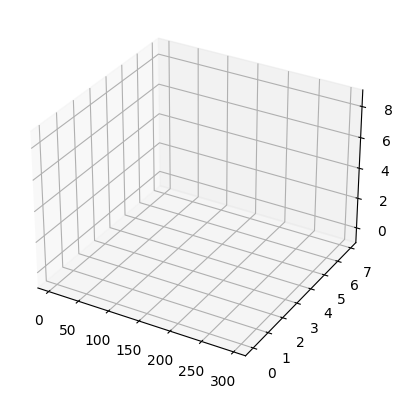

In [21]:
##Visualze data + interpolated curve
##generate a T,H grid
#run getM on the grid
#plot3d

from mpl_toolkits import mplot3d
Tx = []
Hy = []
Mz = []
MHsGen = {}
#can alter this to make a denser set of points in either T or H
for j in range(0,148):
    MH = []
    MT = []
    for i in range(0,70):
        Tx.append(3+2*j)
        Hy.append(0.1*i)
        M = getM(3+2*j,0.1*i)
        Mz.append(M)
        MH.append((0.1*i,M))
    MHsGen[3+2*j] = np.array(MH)
# c = color of the scatter points; bypass this problem by producing separate plots
# 3D scatter plot; pull T, H, M from getM
# Also plot the individual submeasurements in separate 3D plots

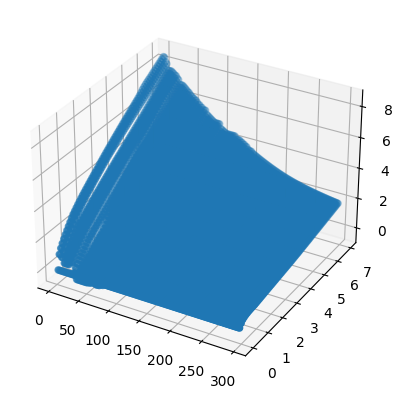

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
#plots T,H,M as 3D plot 
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter3D(Tx,Hy,Mz, marker='o')

In [26]:
#checking the interpolation so I copy one of the keys from here 
print(MHs.keys())
print(MHsGen.keys())

dict_keys([2.0002788376, 5.0025488996, 10.002235041, 20.0003996854, 25.000557251199997, 30.0003868482, 48.011046027800006, 50.006555824399996, 52.0131798554, 56.013354950200004, 60.02068096159999, 62.0221444324, 66.02647460960002, 70.03042038, 75.05079063379999, 100.088492662, 125.118510826, 134.108511658, 138.120646058, 142.13196396200001, 146.13434844000002, 154.166656194, 160.24176971199998, 300.166999208])
dict_keys([3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243, 245, 247, 249, 251, 253

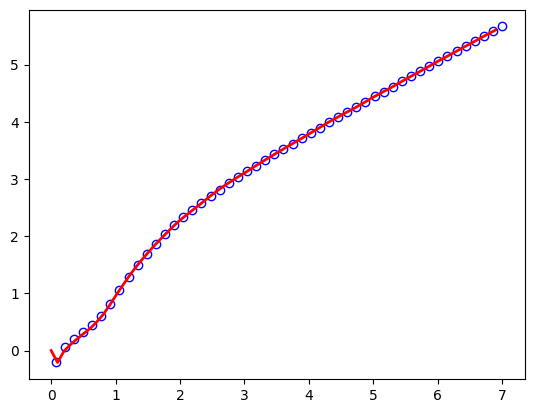

In [29]:
#plot an example MvH curve and the interpolation
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(MHs[75.05079063379999][:,0],MHs[75.05079063379999][:,1],'bo',mfc='none')
plt.plot(MHsGen[75][:,0],MHsGen[75][:,1],'r',linewidth=2)

In [10]:
#set up the data so that we can do can calculate the -dS_M
import pandas as pd
mcetest = [Tx,Hy,Mz]
df = pd.DataFrame(np.asarray(mcetest))
df = pd.DataFrame.transpose(df)
df.columns = ['temp', 'magfield', 'moment']
print(df)

In [13]:
from scikits.datasmooth import regularsmooth
from scipy import integrate
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.interpolate import griddata 
def process_MTs(df,temp_range=None, lmbd=1e-3, individual_lmbds=None, npoints=500, d=2):
   '''
   analyzes DC magnetization data in a dataset of magnetization vs. temperature sweeps at several fields (all in a single dataframe).
   This function requires that all sweeps are taken on cooling, or all sweeps are taken on warming. Warming and cooling sweeps should not both be included
   in the dataframe. However, all, of the sweeps should be in a single dataframe.

   The df should have, as a minimum, the columns:
      "temp" (temperature in K)
      "magfield" (applied magnetic field in T)
      "moment" (magnetic moment in Am^2/kg (emu/g))

   temp_range [None]       : the temperature range in which to analyze the data. If None, limits will be determined from the data automatically
   lmbd [1e-5]             : the regularization parameter used for calculating the derivative of each M(T). Higher values yield larger values. Not read if individual_lmbds != None.
   individual_lmbds [None] : List of floats, length equal to the number of fields in the data set. Specifies a lmbd value for each M(T).
   npoints [500]           : how many temperature points in temp_range to output smoothed magnetization, dM/dT and DeltaSm. 500 is ussually good.
   d [2]                   : order of derivative used to calculate roughness during regularization. If d=2, the 2nd derivative of M(T) is used to calculate the roughness
                             (i.e. the regularization tries to keep the first derivative smooth). Generally  d=2 or d=3 work well. Choice of d will change optimum lmbd.
   '''

   if not temp_range: temp_range=(df["temp"].min()+1,df["temp"].max()-1.) # cut off the first and last 1 K by default

   # properties (smoothed magnetization, dM/dT and deltaSm) will be output at these temperature points.
   xs = np.linspace(temp_range[0],temp_range[1],npoints)

   # split into individual M(T) sweeps, each at a unique field. Rounds to the nearest round_to Tesla before splitting
   round_to = 5e-4 # 0.0005 T = 5 Oe
   byField = df.groupby(lambda x: round_to*np.around(df["magfield"][x]/float(round_to)))
   print("process_MTs: df contains the following distinct magnetic fields and number of records:")
   print("\t(entries with <10 data points will be skipped)")
   print(byField['temp'].count())
 
   #  for the trapezoidal integration, we will need the first point in the derivatives to be (0,0) at each x in xs.
   fields =  [] # holds the unique magnetic fields [floats]
   raws =    [] # holds the raw magnetization data at each field [arrays]
   ders =    [] # holds the calculated derivatives [arrays of len npoints]
   smooths = [] # holds the smoothed data (antiderivatives of ders) [arrays of len npoints]

   for i,(field, data) in enumerate(byField):
      if len(data) < 10: continue # not a real M(T) sweep
      print("process_MTs: processing M(T) at field: {} T".format(field))
      sorted_data = data.sort_values(by="temp")
      try:
         l = individual_lmbds[i] if individual_lmbds else lmbd
      except IndexError: 
         print("process_MTs: individual_lmbds is not long enough")
         raise
      smoothed = regularsmooth.smooth_data(sorted_data.temp.values, sorted_data.moment.values, d=d, derivative=0, lmbd=l, xhat=xs)
      derivative = regularsmooth.smooth_data(sorted_data.temp.values, sorted_data.moment.values, d=d-1, derivative=1, lmbd=l, xhat=xs)

      fields.append(field)
      raws.append(data)
      smooths.append(smoothed)
      ders.append(derivative)

   DSms = np.zeros((len(fields), npoints))
   #do the integration using the trapezoid rule:
   # for the intergration, need the first points to be 0,0
   ders_z = [np.zeros_like(xs)] + ders
   fields_z = np.append([0], fields)
   for i in range(npoints-1):
      der_vals = [d[i] for d in ders_z]
      DSms[:,i] = integrate.cumtrapz(der_vals, x=fields_z)

   return dict(
      raw_data = raws, # list of dataframes with the raw data split by field
      field=fields, # list of fields
      temp_range=temp_range,
      xs=xs, # temperature values used for smoothed data, derivatives, and DSm
      smoothed=smooths,
      derivative=ders,
      DeltaSm=DSms,
      )

The module "cvxopt" is not installed.  Constrained smoothing will not be available.


In [14]:
MC = process_MTs(df)

process_MTs: df contains the following distinct magnetic fields and number of records:
	(entries with <10 data points will be skipped)
0.0    148
0.1    148
0.2    148
0.3    148
0.4    148
      ... 
6.5    148
6.6    148
6.7    148
6.8    148
6.9    148
Name: temp, Length: 70, dtype: int64
process_MTs: processing M(T) at field: 0.0 T
process_MTs: processing M(T) at field: 0.1 T
process_MTs: processing M(T) at field: 0.2 T
process_MTs: processing M(T) at field: 0.3 T
process_MTs: processing M(T) at field: 0.4 T
process_MTs: processing M(T) at field: 0.5 T
process_MTs: processing M(T) at field: 0.6 T
process_MTs: processing M(T) at field: 0.7000000000000001 T
process_MTs: processing M(T) at field: 0.8 T
process_MTs: processing M(T) at field: 0.9 T
process_MTs: processing M(T) at field: 1.0 T
process_MTs: processing M(T) at field: 1.1 T
process_MTs: processing M(T) at field: 1.2 T
process_MTs: processing M(T) at field: 1.3 T
process_MTs: processing M(T) at field: 1.4000000000000001 T
pr

In [16]:
def plot_property_as_lines(p, prop="smoothed", ax=None, cmap_name = "viridis",
 save_to_filename=None, offset=0, show=True):
   ''' plot various results of process_MTs() as curves. Each field will be a different color (set colormap using cmap_name)
   If a nonzero offset is supplied, successive lines will have offset added to them (in the units of the property)
    '''
   available_props = ["raw_data","smoothed","derivative","DeltaSm"]
   if prop not in available_props:
      raise ValueError("prop must be one of: {}".format(available_props))

   if ax is None: ax = plt.gca()

   cmap = plt.get_cmap(cmap_name)
   colors = [cmap(x) for x in np.linspace(0,1,len(p['field']))]
   ax.set_prop_cycle(cycler('color',colors))

   ax.set_xlabel(r"$T\/(\rm{K})$")
   ax.set_xlim(p["temp_range"][0],p["temp_range"][1])

   xs = p['xs']

   if prop=="raw_data":
      [ax.plot(f.temp, f.moment+i*offset,'+') for i,f in enumerate(p["raw_data"])]
      ax.set_ylabel(r"$M$ (A m$^2$ kg$^{-1}$)")
   if prop=="smoothed":
      [ax.plot(f.temp, f.moment+i*offset,'+') for i,f in enumerate(p["raw_data"])]
      [ax.plot(xs, f+i*offset) for f in p["smoothed"]]
      ax.set_ylabel(r"$M$ (A m$^2$ kg$^{-1}$)")
   if prop=="derivative":
      [ax.plot(xs[:-1], f+i*offset, linewidth=2.0) for i,f in enumerate(p["derivative"])]
      #ax.set_ylabel(r"$\rmd\itM/\rmd\itT\/\/(\rm J\/Kg^{-1}\/T^{-1}\/K^{-1})$")
      ax.set_ylabel(r"d$M$/d$T$ (J kg$^{-1}$ K$^{-1}$ T$^{-1}$)")
   if prop=="DeltaSm":
      [ax.plot(xs, -d+i*offset,linewidth=2.0) for i,d in enumerate(p['DeltaSm'])]
      ax.set_ylabel(r"-$\Delta S_M$ (J Kg$^{-1}$K$^{-1})$")

   if save_to_filename: plt.savefig(save_to_filename)
   if show: plt.show()


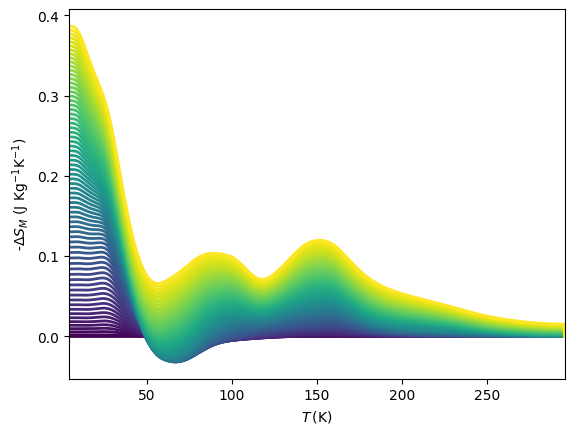

In [17]:
plot_property_as_lines(MC,prop='DeltaSm')

In [19]:
def plot_smoothed_mt_and_dmdt(p, cmap_name="viridis", save_to_filename=None, moment_offset=0, der_offset=0):
   ''' plot smoothed M(T) curves and dM/dT curves from p, the output of process_MTs(). This helps in evaluating whether
       or not the choice of lmbd supplied to process_MTs() was appropriate.
   '''
   fig, (ax1,ax2) =plt.subplots(2,sharex=True, figsize=(4,7))
   plot_property_as_lines(p, prop="smoothed", ax=ax1, cmap_name=cmap_name, save_to_filename=save_to_filename, offset=moment_offset, show=False)
   plot_property_as_lines(p, prop="derivative", ax=ax2, cmap_name=cmap_name, save_to_filename=save_to_filename, offset=der_offset, show=False)
   plt.show()

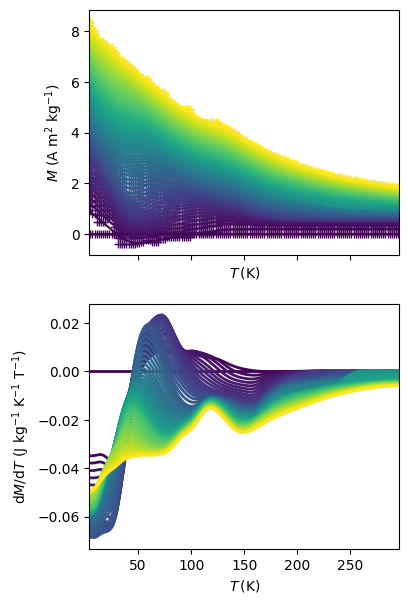

In [20]:
plot_smoothed_mt_and_dmdt(MC)